In [1]:
# get hazard object
import numpy as np
from climada.hazard import Hazard, Centroids
from climada.test import get_test_file

haz_tc_fl = Hazard.from_hdf5(
    get_test_file("HAZ_DEMO_FL_15")
) 
haz_tc_fl.check()  

In [2]:
# compute local exceedance instensity
test_return_periods = np.arange(1, 100, 5)
local_exceedance_intensity, _, _ = haz_tc_fl.local_exceedance_intensity(
    return_periods=test_return_periods, method="extrapolate"
)

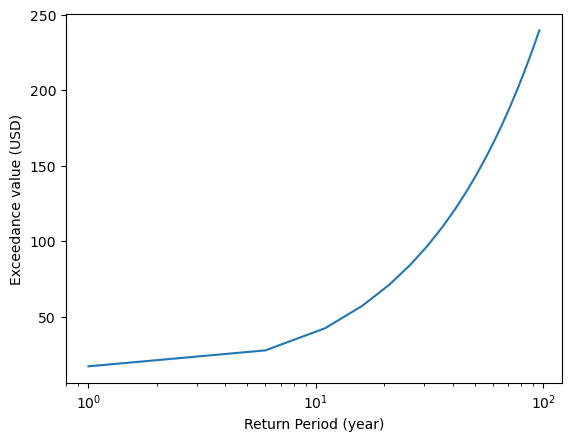

In [13]:
from return_period_maps import ReturnPeriodMap, ExceedanceCurve
rp_map = ReturnPeriodMap.from_CLIMADA_local_exceedance_intensity(local_exceedance_intensity)
rp_map.exceedance_curves[0].plot_exceedance_instensity_curve()

In [14]:
from convert_resolution import combine_exceedance_curves
agg_rp_curve = combine_exceedance_curves(
    [rp_map.exceedance_curves[0]],
    value_resolution=10.,
    aggregation_method=sum)

In [18]:
agg_rp_curve.values

array([ 17.07853667,  27.07853667,  37.07853667,  47.07853667,
        57.07853667,  67.07853667,  77.07853667,  87.07853667,
        97.07853667, 107.07853667, 117.07853667, 127.07853667,
       137.07853667, 147.07853667, 157.07853667, 167.07853667,
       177.07853667, 187.07853667, 197.07853667, 207.07853667,
       217.07853667, 227.07853667, 237.07853667])

In [19]:
agg_rp_curve.frequency_values

array([1.        , 0.16666667, 0.        , 0.09090909, 0.0625    ,
       0.04761905, 0.        , 0.03846154, 0.03225806, 0.02777778,
       0.02439024, 0.        , 0.02173913, 0.01960784, 0.01785714,
       0.01639344, 0.01515152, 0.01408451, 0.01315789, 0.01234568,
       0.01162791, 0.01098901, 0.01041667])

<string>:4: RuntimeWarning: divide by zero encountered in divide


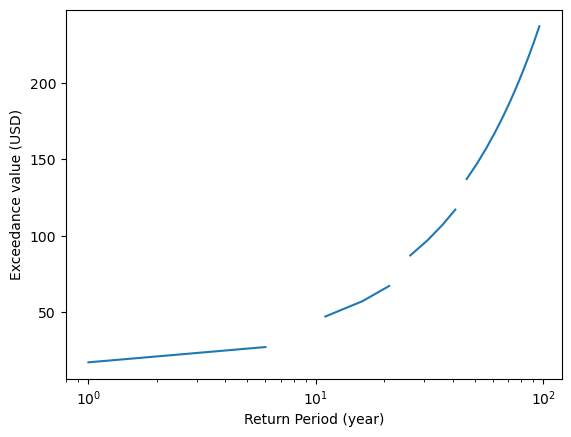

In [17]:
agg_rp_curve.plot_exceedance_instensity_curve()


<string>:4: RuntimeWarning: divide by zero encountered in divide


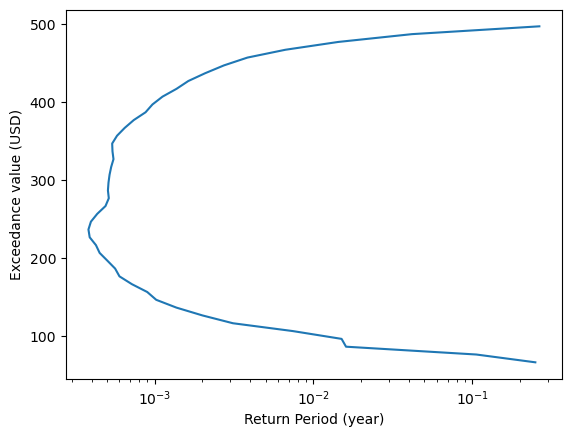

In [8]:
agg_rp_curve.plot_exceedance_instensity_curve()